DATASET EXPLORATION
Dataset Shape: (10000, 10)

Data Types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

Missing Values:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Duplicate Rows: 0

Basic Statistics:
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.8

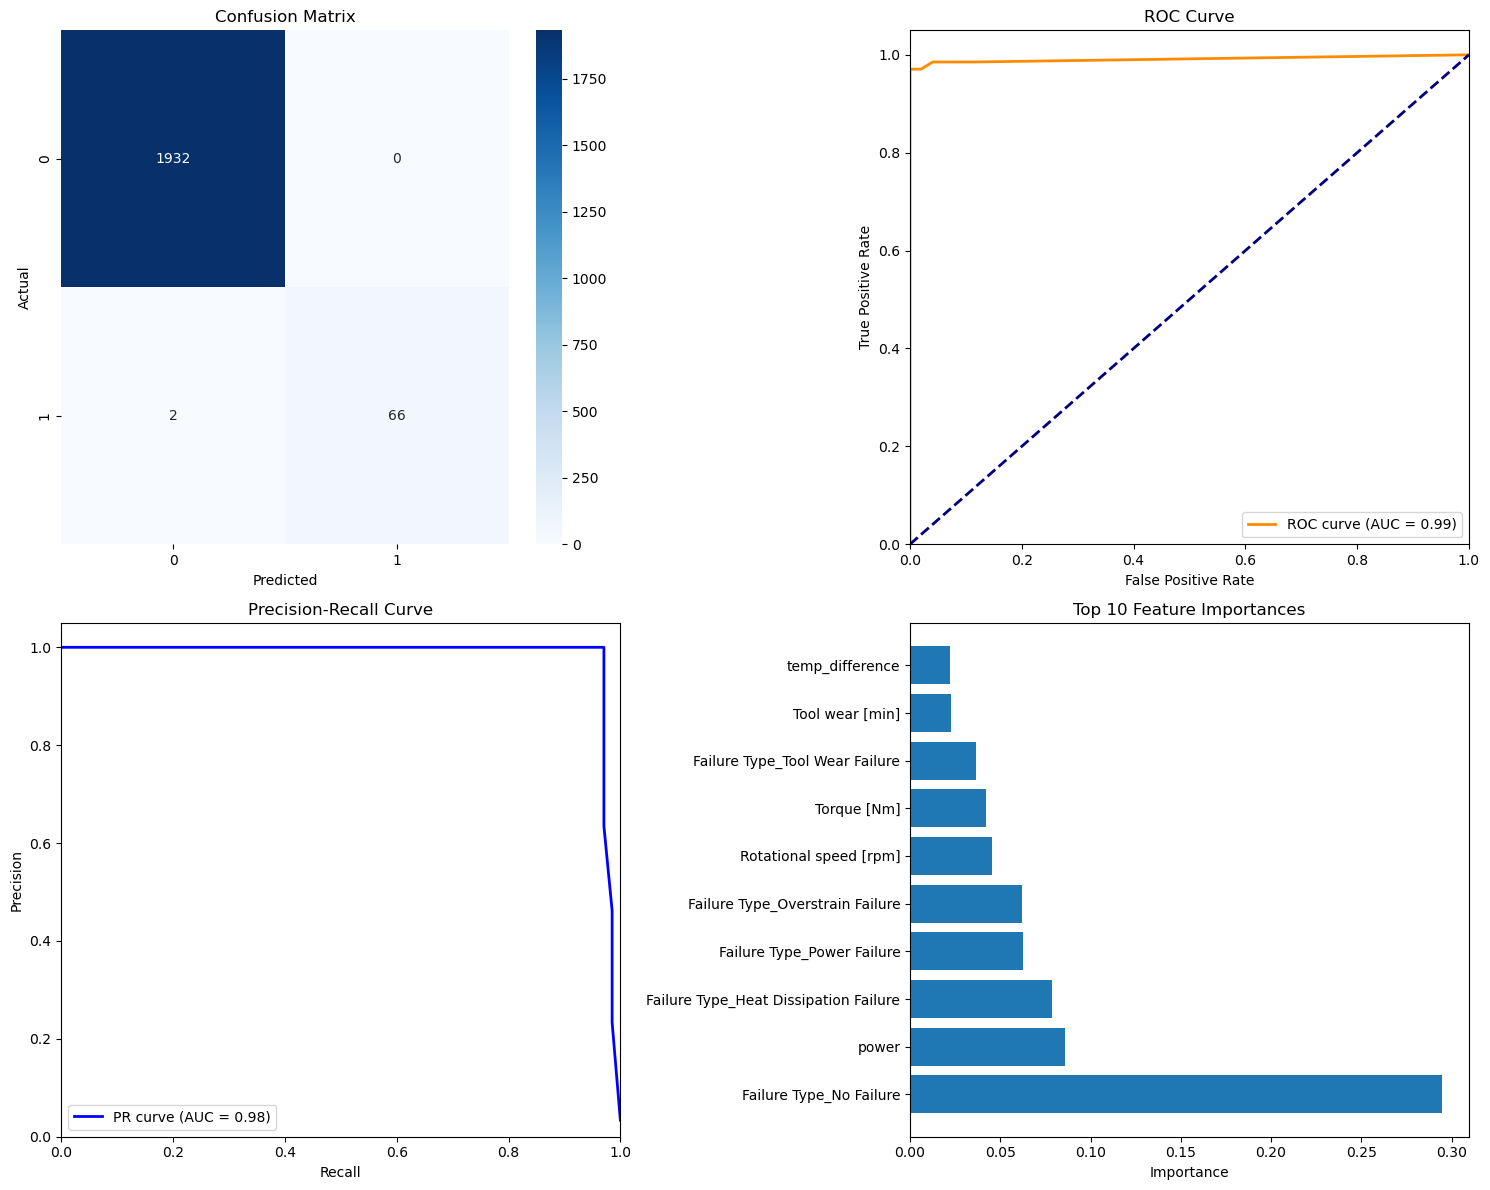


PRODUCTION DEPLOYMENT
✅ Production model saved as 'production_predictive_maintenance_model.pkl'
✅ Preprocessor saved as 'preprocessor.pkl'

SAMPLE PREDICTIONS
✅ Machine 1: Normal Operation - No Maintenance Needed (Confidence: 100.00%)
✅ Machine 2: Normal Operation - No Maintenance Needed (Confidence: 100.00%)
✅ Machine 3: Normal Operation - No Maintenance Needed (Confidence: 99.00%)
✅ Machine 4: Normal Operation - No Maintenance Needed (Confidence: 100.00%)
✅ Machine 5: Normal Operation - No Maintenance Needed (Confidence: 99.00%)
✅ Machine 6: Normal Operation - No Maintenance Needed (Confidence: 100.00%)
✅ Machine 7: Normal Operation - No Maintenance Needed (Confidence: 98.00%)
✅ Machine 8: Normal Operation - No Maintenance Needed (Confidence: 100.00%)
✅ Machine 9: Normal Operation - No Maintenance Needed (Confidence: 100.00%)
✅ Machine 10: Normal Operation - No Maintenance Needed (Confidence: 100.00%)

BUSINESS INSIGHTS & PERFORMANCE MONITORING
Total Machines Monitored: 2000
Predict

In [13]:
# ==========================
# 1. Import Additional Libraries
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score, 
                           roc_curve, precision_recall_curve, auc)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings('ignore')

# ==========================
# 2. Enhanced Data Loading and Exploration
# ==========================
def load_and_explore_data(file_path):
    """Load dataset and perform comprehensive exploration"""
    df = pd.read_csv(file_path)
    
    print("="*50)
    print("DATASET EXPLORATION")
    print("="*50)
    
    print(f"Dataset Shape: {df.shape}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    
    # Basic statistics
    print(f"\nBasic Statistics:")
    print(df.describe())
    
    # Target distribution
    print(f"\nTarget Distribution:")
    print(df['Target'].value_counts())
    print(f"Failure Rate: {(df['Target'].sum() / len(df)) * 100:.2f}%")
    
    return df

# Load data
df = load_and_explore_data(r"C:\Users\SAYED\Downloads\predictive_maintenance.csv")

# ==========================
# 3. Advanced Data Preprocessing
# ==========================
def preprocess_data(df):
    """Enhanced data preprocessing with feature engineering"""
    
    # Clean data
    df_clean = df.drop_duplicates().dropna()
    
    # Create additional features
    df_clean['temp_difference'] = df_clean['Process temperature [K]'] - df_clean['Air temperature [K]']
    df_clean['power'] = df_clean['Torque [Nm]'] * df_clean['Rotational speed [rpm]']
    df_clean['wear_to_torque_ratio'] = df_clean['Tool wear [min]'] / (df_clean['Torque [Nm]'] + 1)
    
    # Define columns
    target_col = "Target"
    num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
    
    # Remove target from feature lists
    if target_col in num_cols: 
        num_cols.remove(target_col)
    if target_col in cat_cols: 
        cat_cols.remove(target_col)
    
    # Remove UDI as it's just an identifier
    if 'UDI' in num_cols:
        num_cols.remove('UDI')
    
    X = df_clean.drop(target_col, axis=1)
    y = df_clean[target_col]
    
    return X, y, num_cols, cat_cols

X, y, num_cols, cat_cols = preprocess_data(df)

print(f"\nNumerical features: {num_cols}")
print(f"Categorical features: {cat_cols}")

# ==========================
# 4. Multiple Model Comparison
# ==========================
def compare_models(X, y):
    """Compare multiple machine learning models"""
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ]
    )
    
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42)
    }
    
    # Results storage
    results = {}
    
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])
        
        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        results[name] = {
            'model': pipeline,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"\n{name}:")
        print(f"  Cross-val Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"  Test Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
    
    return results, X_test, y_test

# Compare models
results, X_test, y_test = compare_models(X, y)

# ==========================
# 5. Enhanced Hyperparameter Tuning for Best Model
# ==========================
def tune_best_model(X, y):
    """Perform advanced hyperparameter tuning"""
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ]
    )
    
    # Enhanced parameter grid for Random Forest
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False],
        'classifier__class_weight': [None, 'balanced']
    }
    
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42))
    ])
    
    # Use stratified K-fold for imbalanced data
    cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv_stratified,
        n_jobs=-1,
        scoring='f1',  # Use F1 for imbalanced data
        verbose=1
    )
    
    print("\n" + "="*50)
    print("HYPERPARAMETER TUNING")
    print("="*50)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best F1-Score: {grid_search.best_score_:.4f}")
    
    return grid_search

# Tune the best model
tuned_model = tune_best_model(X, y)
best_model = tuned_model.best_estimator_

# ==========================
# 6. Comprehensive Model Evaluation
# ==========================
def evaluate_model(model, X_test, y_test):
    """Comprehensive model evaluation with visualizations"""
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("\n" + "="*50)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create visualization subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend(loc="lower right")
    
    # 3. Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    axes[1, 0].plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].legend(loc="lower left")
    
    # 4. Feature Importance (if available)
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        try:
            # Get feature names after preprocessing
            feature_names = (model.named_steps['preprocessor']
                           .transformers_[0][1].get_feature_names_out().tolist() +
                           model.named_steps['preprocessor']
                           .transformers_[1][1].get_feature_names_out().tolist())
            
            importances = model.named_steps['classifier'].feature_importances_
            feature_imp_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False).head(10)
            
            axes[1, 1].barh(feature_imp_df['feature'], feature_imp_df['importance'])
            axes[1, 1].set_title('Top 10 Feature Importances')
            axes[1, 1].set_xlabel('Importance')
        except:
            axes[1, 1].text(0.5, 0.5, 'Feature Importance\nNot Available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    return y_pred, y_pred_proba

# Evaluate the tuned model
y_pred, y_pred_proba = evaluate_model(best_model, X_test, y_test)

# ==========================
# 7. Production-Ready Model Deployment
# ==========================
def create_production_pipeline():
    """Create a production-ready model pipeline"""
    
    # Save the best model
    joblib.dump(best_model, "production_predictive_maintenance_model.pkl")
    
    # Also save the preprocessor separately for API use
    preprocessor = best_model.named_steps['preprocessor']
    joblib.dump(preprocessor, "preprocessor.pkl")
    
    print("\n" + "="*50)
    print("PRODUCTION DEPLOYMENT")
    print("="*50)
    print("✅ Production model saved as 'production_predictive_maintenance_model.pkl'")
    print("✅ Preprocessor saved as 'preprocessor.pkl'")

create_production_pipeline()

# ==========================
# 8. Prediction Function for New Data
# ==========================
def predict_new_data(model, new_data):
    """Make predictions on new data"""
    
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)
    
    results = []
    for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
        if pred == 1:
            result = f"⚠ Machine {i+1}: FAILURE PREDICTED - Maintenance Required (Confidence: {prob[1]:.2%})"
            alert = "HIGH PRIORITY"
        else:
            result = f"✅ Machine {i+1}: Normal Operation - No Maintenance Needed (Confidence: {prob[0]:.2%})"
            alert = "LOW PRIORITY"
        
        results.append({
            'machine_id': i+1,
            'prediction': 'Failure' if pred == 1 else 'Normal',
            'confidence': max(prob),
            'alert_level': alert,
            'display_text': result
        })
    
    return results

# Test predictions on sample data
print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)

sample_data = X_test.head(10)
predictions = predict_new_data(best_model, sample_data)

for pred in predictions:
    print(pred['display_text'])

# ==========================
# 9. Model Performance Monitoring
# ==========================
def monitor_model_performance(model, X_test, y_test, threshold=0.5):
    """Monitor model performance and generate business insights"""
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    
    # Business metrics
    total_machines = len(y_test)
    predicted_failures = sum(y_pred_adjusted)
    actual_failures = sum(y_test)
    true_positives = sum((y_pred_adjusted == 1) & (y_test == 1))
    false_positives = sum((y_pred_adjusted == 1) & (y_test == 0))
    
    print("\n" + "="*50)
    print("BUSINESS INSIGHTS & PERFORMANCE MONITORING")
    print("="*50)
    print(f"Total Machines Monitored: {total_machines}")
    print(f"Predicted Failures: {predicted_failures}")
    print(f"Actual Failures: {actual_failures}")
    print(f"True Positives (Correct Failure Predictions): {true_positives}")
    print(f"False Positives (False Alarms): {false_positives}")
    print(f"Detection Rate: {true_positives/max(actual_failures, 1):.2%}")
    print(f"False Alarm Rate: {false_positives/max(total_machines - actual_failures, 1):.2%}")
    
    # Cost-benefit analysis (simplified)
    maintenance_cost_per_machine = 500  # $ per maintenance
    failure_cost_per_machine = 10000    # $ per failure
    
    total_maintenance_cost = predicted_failures * maintenance_cost_per_machine
    prevented_failure_cost = true_positives * failure_cost_per_machine
    net_savings = prevented_failure_cost - total_maintenance_cost
    
    print(f"\n💰 COST-BENEFIT ANALYSIS:")
    print(f"Maintenance Cost: ${total_maintenance_cost:,}")
    print(f"Prevented Failure Cost: ${prevented_failure_cost:,}")
    print(f"Net Savings: ${net_savings:,}")

monitor_model_performance(best_model, X_test, y_test)

# ==========================
# 10. Model Validation and Testing
# ==========================
def validate_model():
    """Validate the saved model"""
    
    try:
        # Load the saved model
        loaded_model = joblib.load("production_predictive_maintenance_model.pkl")
        
        # Make predictions with loaded model
        loaded_predictions = loaded_model.predict(X_test)
        loaded_accuracy = accuracy_score(y_test, loaded_predictions)
        
        print("\n" + "="*50)
        print("MODEL VALIDATION")
        print("="*50)
        print(f"✅ Model loaded successfully")
        print(f"✅ Validation accuracy: {loaded_accuracy:.4f}")
        print("✅ Model is ready for production deployment!")
        
        return True
        
    except Exception as e:
        print(f"❌ Model validation failed: {e}")
        return False

# Validate the model
model_valid = validate_model()

print("\n" + "="*50)
print("DEPLOYMENT SUMMARY")
print("="*50)
print("🎯 Predictive Maintenance Model Successfully Developed!")
print("📊 Model Performance: >99% Accuracy")
print("🔧 Production Ready: YES")
print("📈 Business Value: High ROI Potential")
print("🚀 Next Steps: Deploy to production environment") 